# Replace the coeff in the .XML files

I'm going to modify the `.xml` file so it has non-zero tilt and temp coff to see if I can get echoview to run


The main issue is that with the `Analog_Temperature` coefficents in the `.xml` file, the `compute_temperature()` function in `Convert`,`azfp.py` would give a negative value and raise an error when the function took the log. This is beause teh ad counts in from the instrument were larger than the `kc` constant, and thus we'd get a negative. 


This is a weird thing, and a strange hack, but I just increased the the `kc` constant so that the values remained positive. but the temp (and tilt) values are meaningless and need to be replaced with real values from the glider

# To Do:

1. check what time the azfp and glider is in
1. load the glider data for T, S, depth, pitch, roll
1. check the pitch, roll units and conventions in the echopype processing
    1. should be in the azfp manual
1. add the glider data into the netcdf file after `Convert`
    1. interpolate glider T, S, depth, pitch, roll onto AZFP time
    1. check that you add the data to the correct group
1. run `Process` with the glider data added in the right places
1. learn how to customize `Process`, e.g. bin sizes for MBVS etc
1. Make sure to have a `coord` with depth in the final dataset so you can see the glider dive behavior
1. Process stuff, like find the bottom (maybe look here https://github.com/CI-CMG/pyEcholab ), or at edge detection : https://datacarpentry.org/image-processing/08-edge-detection/, or https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html#sphx-glr-auto-examples-edges-plot-canny-py

In [2]:
from echopype.convert import Convert
from echopype import Process


import numpy as np


import xarray as xr

import matplotlib.pyplot as plt

In [3]:
# fname = './data/19011717'

# fname = '19010215'
fname = '19010215'
fname = '19011711'

data_tmp = Convert('./data/' + fname + '.01A', './data/NLB_test.XML')

In [4]:
data_tmp.raw2nc(save_path='./')

10:12:54 converting file 19011711.01A with NLB_test.XML, time of first ping 2019-Jan-17 11:00:00
          ... this file has already been converted to .nc, conversion not executed.


In [5]:
data_tmp.parameters

{'num_freq': 3,
 'serial_number': 59006,
 'burst_interval': 3.0,
 'pings_per_burst': 1,
 'average_burst_pings': 0,
 'ka': 532.6859171,
 'kb': 3000.0,
 'kc': 2.870441838,
 'A': 0.001466,
 'B': 0.000238809,
 'C': 1.00335e-07,
 'X_a': 0.0,
 'X_b': 0.0,
 'X_c': 0.0,
 'X_d': 0.0,
 'Y_a': 0.0,
 'Y_b': 0.0,
 'Y_c': 0.0,
 'Y_d': 0.0,
 'dig_rate': [20000.0, 20000.0, 20000.0],
 'lock_out_index': [0.0, 0.0, 0.0],
 'gain': [1.0, 1.0, 1.0],
 'pulse_length': [1000.0, 1000.0, 1000.0],
 'DS': [0.02290000021458, 0.02270000055432, 0.02199999988079],
 'EL': [152.3999938965, 136.3999938965, 151.6000061035],
 'TVR': [156.1999969482, 168.5, 165.8999938965],
 'VTX': [157.0, 146.6999969482, 133.3000030518],
 'BP': [0.1306499987841, 0.0107100000605, 0.0107100000605],
 'range_samples': [1999, 1999, 1999],
 'range_averaging_samples': [1, 1, 1],
 'sensors_flag': 0.0}

In [5]:
ds = xr.open_dataset(fname +'.nc', group='Beam')
ds

<xarray.Dataset>
Dimensions:                                         (frequency: 3, ping_time: 421, range_bin: 1999)
Coordinates:
  * frequency                                       (frequency) int64 38000 ....
  * ping_time                                       (ping_time) datetime64[ns] ...
  * range_bin                                       (range_bin) int64 0 ... 1998
Data variables:
    backscatter_r                                   (frequency, ping_time, range_bin) int64 ...
    equivalent_beam_angle                           (frequency) float64 ...
    gain_correction                                 (frequency) float64 ...
    sample_interval                                 (frequency) float64 ...
    transmit_duration_nominal                       (frequency) float64 ...
    temperature_counts                              (ping_time) int64 ...
    tilt_x_count                                    (ping_time) int64 ...
    tilt_y_count                                    (ping_time) int64 ...
    tilt_x                                          (ping_time) float64 ...
    tilt_y                                          (ping_time) float64 ...
    cos_tilt_mag                                    (ping_time) float64 ...
    DS                                              (frequency) float64 ...
    EL                                              (frequency) float64 ...
    TVR                                             (frequency) float64 ...
    VTX                                             (frequency) float64 ...
    Sv_offset                                       (frequency) float64 ...
    number_of_samples_digitized_per_pings           (frequency) int64 ...
    number_of_digitized_samples_averaged_per_pings  (frequency) int64 ...
Attributes:
    beam_mode:                  
    conversion_equation_t:      type_4
    number_of_frequency:        3
    number_of_pings_per_burst:  1
    average_burst_pings_flag:   0
    temperature_ka:             532.6859171
    temperature_kb:             3000.0
    temperature_kc:             2.870441838
    temperature_A:              0.001466
    temperature_B:              0.000238809
    temperature_C:              1.00335e-07
    tilt_X_a:                   0.0
    tilt_X_b:                   0.0
    tilt_X_c:                   0.0
    tilt_X_d:                   0.0
    tilt_Y_a:                   0.0
    tilt_Y_b:                   0.0
    tilt_Y_c:                   0.0
    tilt_Y_d:                   0.0

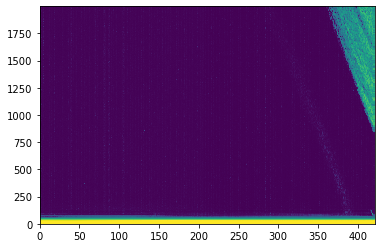

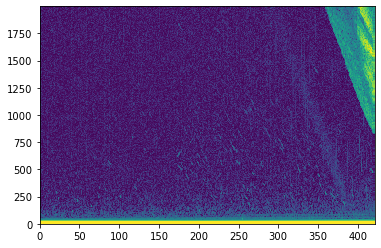

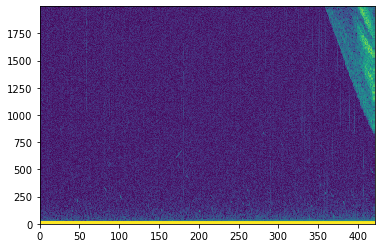

In [6]:
for f in ds.frequency:
    plt.figure()
    plt.pcolormesh( ds.backscatter_r.sel(frequency = f).T )
#     ds.backscatter_r.sel(frequency = f).plot()

In [8]:
import glob
glob.glob('./*.nc')

['./19011711.nc', './combined_file.nc', './19011717.nc', './19010215.nc']

In [12]:
from echopype import Process
nc_path = fname + '.nc'  # path to a converted nc file
# nc_path =glob.glob('./*.nc') # try to look at many files
ed = Process(nc_path)   # create a processing object
# ed.temperature = -1   # temperature in degree Celsius
# ed.salinity = 34.5     # salinity in PSU
# ed.pressure = 50     # pressure in dbar
# ed.recalculate_environment()  # recalculate related parameters

ed.calibrate()           # Sv
ed.remove_noise()        # denoise
ed.get_MVBS()  

Initialize using average temperature recorded by instrument
13:31:27  calibrating data in 19011711.nc
13:31:27  Remove noise from Sv stored in memory.
13:31:27  use Sv stored in memory to calculate MVBS


In [13]:
ed.sound_speed

1450.7071675728184

In [8]:
ed.Sv_clean

<xarray.Dataset>
Dimensions:                   (frequency: 3, ping_time: 569, range_bin: 1999)
Coordinates:
  * frequency                 (frequency) int64 38000 125000 200000
  * ping_time                 (ping_time) datetime64[ns] 2019-01-02T15:00:01 ...
  * range_bin                 (range_bin) int64 0 1 2 3 ... 1995 1996 1997 1998
Data variables:
    Sv                        (frequency, ping_time, range_bin) float64 -114....
    noise_est_range_bin_size  (frequency) float64 4.984 4.984 4.984
    range                     (frequency, range_bin) float64 0.3611 ... 72.52
Attributes:
    noise_est_ping_size:  30

<ipython-input-10-cbcc8e20ccfd>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Sv.ping_time , Sv.range,  Sv.Sv.T ,
<ipython-input-10-cbcc8e20ccfd>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Sv.ping_time , Sv.range,  Sv.Sv.T ,
<ipython-input-10-cbcc8e20ccfd>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals 

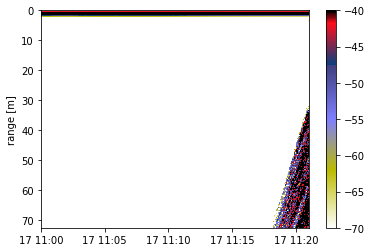

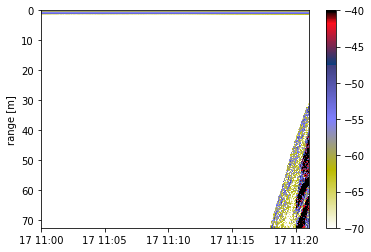

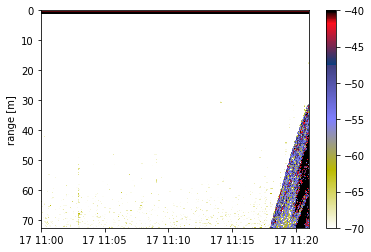

In [10]:
for f in ed.Sv_clean.frequency:
    plt.figure()
    
    Sv = ed.Sv_clean.sel(frequency = f)
    plt.pcolormesh(Sv.ping_time , Sv.range,  Sv.Sv.T , 
                   cmap='gist_stern_r', vmin=-70, vmax = -40  )
    plt.ylim([ Sv.range.max() , 0])
    plt.ylabel('range [m]')
    plt.colorbar()

In [10]:
ed.MVBS

<xarray.Dataset>
Dimensions:              (frequency: 3, ping_time: 19, range_bin: 15)
Coordinates:
  * frequency            (frequency) int64 38000 125000 200000
  * ping_time            (ping_time) datetime64[ns] 2019-01-02T15:00:44.50000...
  * range_bin            (range_bin) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    ping_idx             (ping_time) float64 14.5 44.5 74.5 ... 524.5 554.0
Data variables:
    MVBS                 (frequency, ping_time, range_bin) float64 -41.77 ......
    MVBS_range_bin_size  (frequency) float64 4.984 4.984 4.984
Attributes:
    MVBS_ping_size:  30

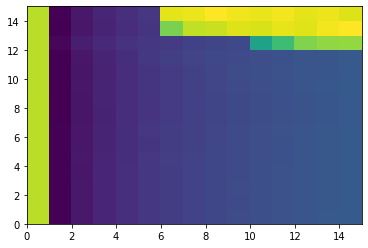

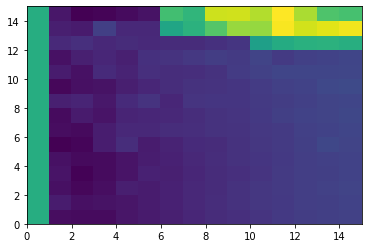

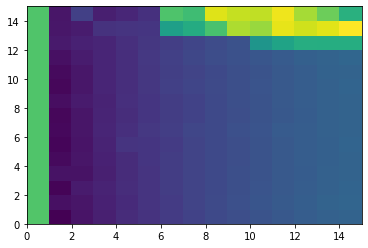

In [11]:
for f in ed.MVBS.frequency:
    plt.figure()
    plt.pcolormesh(ed.MVBS.MVBS.sel(frequency = f)  )